raterizing one storm

In [176]:
# import warnings
# # https://github.com/slundberg/shap/issues/2909    (suppresing the one from numba 0.59.0)
# warnings.filterwarnings('ignore', message=".*The 'nopython' keyword.*")
# # https://stackoverflow.com/a/9134842/5885810     (supress warning by message)
# warnings.filterwarnings('ignore', message='You will likely lose important projection '\
#                         'information when converting to a PROJ string from another format')
# # because the "EPSG_CODE = 42106" is not a standard proj?
# warnings.filterwarnings('ignore', message="GeoDataFrame's CRS is not representable in URN OGC format")

from statsmodels.distributions.copula.api import GaussianCopula
from numpy import random as npr
from scipy import stats
import numpy as np
from pointpats import random as pran
import geopandas as gpd
import pandas as pd
import pyproj as pp
from osgeo import gdal
from rasterio import fill
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import cmaps
from cmcrameri import cm as cmc

In [ ]:
raterizing one storm

In [13]:
COPULA = {'':-0.31622, 'Z1':-0.276457, 'Z2':-0.312464, 'Z3':-0.44}
MAXINT = {'':stats.expon(0.1057 ,6.9955)}
AVGDUR = {'':stats.geninvgauss(-0.089, 0.77, 2.8432, 82.0786)}
RADIUS = {'':stats.johnsonsb(1.5187, 1.2696, -0.2789, 20.7977)}
BETPAR = {'':stats.exponnorm(8.2872, 0.0178 ,0.01)}

In [60]:
n_s = 3
BAND = ''


IntDur = GaussianCopula(corr=COPULA[ BAND ], k_dim=2).rvs( nobs=n_s ).reshape(-1, 2)
# # for reproducibility
# IntDur = GaussianCopula(corr=COPULA[ BAND ], k_dim=2).rvs( nobs=n_s, random_state=npr.RandomState(npr.PCG64(232))).reshape(-1, 2)
IntDur = GaussianCopula(corr=COPULA[ BAND ], k_dim=2).rvs( nobs=n_s, random_state=npr.RandomState(npr.PCG64(5669876))).reshape(-1, 2)
MAX_I = MAXINT[ BAND ].ppf( IntDur[:, 0] )
DUR_S = AVGDUR[ BAND ].ppf( IntDur[:, 1] )

print(MAX_I)
print(DUR_S)

# [3.62776653 8.20171748 0.16752468]
# [ 85.94128227  80.52085901 242.84382275]

[6.70551677 1.84085664 9.93770232]
[239.73002819 558.8315374   57.29891514]


some truncated sampling

In [254]:
X_RES     =  5000.                      # in meters! (pxl.resolution for the 'regular/local' CRS)
Y_RES     =  5000.                      # in meters! (pxl.resolution for the 'regular/local' CRS)
MINRADIUS =  max([X_RES, Y_RES]) /1e3
BUFFER    =     8000.                                   # in meters! -> buffer distance (out of the HAD)


lim_ts = [1* MINRADIUS, None]
LIMITS = [RADIUS[ BAND ].cdf(x) if x else None for x in lim_ts]

# if None in LIMITS:
# # https://stackoverflow.com/a/50049044/5885810  (None to NaN to Zero)
#     LIMITS = np.nan_to_num( np.array(LIMITS, dtype='f8') ) + np.r_[0, 1]

LIMITS = np.nan_to_num( np.array(LIMITS, dtype='f8') ) + np.r_[0, 1] if None in LIMITS else LIMITS

npr.seed( 894765 )
RADII = RADIUS[ BAND ].ppf( npr.uniform(LIMITS[0], LIMITS[-1], size=n_s) )

print(RADII )

[13.11900959  8.92419382  5.01969002]


In [255]:
RADII = RADII *5.5

print(RADII )

[72.15455275 49.08306603 27.60829509]


In [99]:
# npr.seed( 268876 )
npr.seed( 233 )
BETAS = BETPAR[ BAND ].rvs( size=n_s )

print( BETAS )

# [0.11909295 0.16403334 0.05828189]


[0.02841443 0.20982082 0.10673361]


In [276]:
# OGC-WKT for HAD [taken from https://epsg.io/42106]
WKT_OGC = 'PROJCS["WGS84_/_Lambert_Azim_Mozambique",'\
    'GEOGCS["unknown",'\
        'DATUM["unknown",'\
            'SPHEROID["Normal Sphere (r=6370997)",6370997,0]],'\
        'PRIMEM["Greenwich",0,'\
            'AUTHORITY["EPSG","8901"]],'\
        'UNIT["degree",0.0174532925199433,'\
            'AUTHORITY["EPSG","9122"]]],'\
    'PROJECTION["Lambert_Azimuthal_Equal_Area"],'\
    'PARAMETER["latitude_of_center",5],'\
    'PARAMETER["longitude_of_center",20],'\
    'PARAMETER["false_easting",0],'\
    'PARAMETER["false_northing",0],'\
    'UNIT["metre",1,'\
        'AUTHORITY["EPSG","9001"]],'\
    'AXIS["Easting",EAST],'\
    'AXIS["Northing",NORTH],'\
    'AUTHORITY["EPSG","42106"]]'

wtrwgs = gpd.read_file( '../model_input/HAD_basin.shp' )
wtrshd = wtrwgs.to_crs( crs = WKT_OGC )          # //epsg.io/42106.wkt
CATCHM = gpd.GeoDataFrame( geometry=wtrshd.geometry )#.to_crs(epsg=4326)

BUFFRX = gpd.GeoDataFrame( geometry=wtrshd.buffer( BUFFER ) )#.to_crs(epsg=4326)

print(CATCHM )

# # infering (and rounding) the limits of the buffer-zone
# llim = np.floor( CATCHM.bounds.minx[0] /X_RES ) *X_RES #+X_RES/2
# rlim = np.ceil(  CATCHM.bounds.maxx[0] /X_RES ) *X_RES #-X_RES/2
# blim = np.floor( CATCHM.bounds.miny[0] /Y_RES ) *Y_RES #+Y_RES/2
# tlim = np.ceil(  CATCHM.bounds.maxy[0] /Y_RES ) *Y_RES #-Y_RES/2
# infering (and rounding) the limits of the buffer-zone
llim = np.floor( BUFFRX.bounds.minx[0] /X_RES ) *X_RES #+X_RES/2
rlim = np.ceil(  BUFFRX.bounds.maxx[0] /X_RES ) *X_RES #-X_RES/2
blim = np.floor( BUFFRX.bounds.miny[0] /Y_RES ) *Y_RES #+Y_RES/2
tlim = np.ceil(  BUFFRX.bounds.maxy[0] /Y_RES ) *Y_RES #-Y_RES/2

# DEFINE THE COORDINATES OF THE XY.AXES
XS, YS = list(map( lambda a,b,c: np.arange(a +c/2, b +c/2, c), [llim,blim], [rlim,tlim], [X_RES,Y_RES] ))
# flip YS??
YS = np.flipud( YS )      # -> important...so rasters are compatible with numpys

                                            geometry
0  POLYGON ((2543226.299 767453.737, 2545070.786 ...


In [145]:

npr.seed( 546846 )
CENTS = pran.poisson( CATCHM.geometry.xs(0), size=n_s )

print( CENTS )

[[2505448.49327476  841520.4188831 ]
 [2278457.56241648  703196.79461003]
 [2082039.98979901 -825624.9487317 ]]


In [146]:
CLOSE_DIS =  0.15                       # in km -> small circle emulating the storm centre's point/dot
RINGS_DIS =  MINRADIUS *(2) +.1         # in km -> distance between (rainfall) rings; heavily dependant on X_Y_RES

print(RINGS_DIS) 

all_radii = list(map(lambda r: np.r_[np.arange(r, CLOSE_DIS, -RINGS_DIS), CLOSE_DIS], RADII))

all_radii

10.1


[array([72.15455275, 62.05455275, 51.95455275, 41.85455275, 31.75455275,
        21.65455275, 11.55455275,  1.45455275,  0.15      ]),
 array([49.08306603, 38.98306603, 28.88306603, 18.78306603,  8.68306603,
         0.15      ]),
 array([27.60829509, 17.50829509,  7.40829509,  0.15      ])]

In [147]:
all_rain = list(map(lambda i,d,b,r: list(map( lambda r:
# # model: FORCE_BRUTE -> a * np.exp(-2 * b * x**2)
#     i * d *1/60 * np.exp( -2* b * r**2 ), r)), MAX_I, DUR_S, BETAS, all_radii))
# model: BRUTE_FORCE -> a * np.exp(-2 * b**2 * x**2)
    i * d *1/60 * np.exp( -2* b**2 * r**2 ), r)), MAX_I, DUR_S, BETAS, all_radii))

all_rain

[[0.005983238754889605,
  0.053398824773079785,
  0.34280853641774955,
  1.5830554240756662,
  5.2585399246679545,
  12.564892990989849,
  21.59618187118039,
  26.7005201184977,
  26.790922020930523],
 [1.2874081948229739e-91,
  1.3257668677168718e-57,
  2.1558006804063954e-31,
  5.53529280643682e-13,
  0.022442082000436195,
  17.111545600057266],
 [2.72344971628483e-07,
  0.008791395955391681,
  2.7177805325374034,
  9.485462130217563]]


*now you do something*


In [148]:

# BUFFER_STRINGS
# https://www.knowledgehut.com/blog/programming/python-map-list-comprehension
# https://stackoverflow.com/a/30061049/5885810  (map nest)
# r,p are lists (at first instance), and the numbers/atoms (in the second lambda)
# .boundary gives the LINESTRING element
# *1e3 to go from km to m
# np.ceil(r /MINRADIUS) +2 ) is an artifact to lower the resolution of small circles
# ...a lower resolution in such circles increases the script.speed in the rasterisation process.
RINGS = list(map(lambda c,r,p: pd.concat( list(map(lambda r,p: gpd.GeoDataFrame(
    {'rain':p, 'geometry':gpd.points_from_xy( x=[c[0]], y=[c[1]] ).buffer( r *1e3,
        resolution=np.ceil(r /MINRADIUS) +2 ).boundary}, # or maybe... "+1"??
    crs=WKT_OGC) , r, p)) ), CENTS, all_radii, all_rain))

RINGS


[        rain                                           geometry
 0   0.005983  LINESTRING (2577603.046 841520.419, 2577295.24...
 0   0.053399  LINESTRING (2567503.046 841520.419, 2567163.10...
 0   0.342809  LINESTRING (2557403.046 841520.419, 2557024.23...
 0   1.583055  LINESTRING (2547303.046 841520.419, 2546877.02...
 0   5.258540  LINESTRING (2537203.046 841520.419, 2536720.62...
 0  12.564893  LINESTRING (2527103.046 841520.419, 2526560.12...
 0  21.596182  LINESTRING (2517003.046 841520.419, 2516437.52...
 0  26.700520  LINESTRING (2506903.046 841520.419, 2506708.17...
 0  26.790922  LINESTRING (2505598.493 841520.419, 2505578.39...,
            rain                                           geometry
 0  1.287408e-91  LINESTRING (2327540.628 703196.795, 2327120.71...
 0  1.325767e-57  LINESTRING (2317440.628 703196.795, 2316960.68...
 0  2.155801e-31  LINESTRING (2307340.628 703196.795, 2306785.64...
 0  5.535293e-13  LINESTRING (2297240.628 703196.795, 2296600.61...
 0  2.244

In [149]:

posx = 0 # 0, 1 or 2 -> because we're only having n_s==3
ALL_RINGS = RINGS[ posx ]


In [293]:

# #~ RASTERIZE SHPs & INTERPOLATE RAINFALL (between rings) ~~~~~~~~~~~~~~~~~~~~~~#
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# def RASTERIZE( ALL_RINGS ):# posx=23; ALL_RINGS=RINGS[posx]

# burn the ALL_RINGS
tmp = gdal.Rasterize('', ALL_RINGS.to_json(), xRes=X_RES, yRes=Y_RES, allTouched=True,
    attribute='rain', noData=0, outputType=gdal.GDT_Float64, targetAlignedPixels=True,
    outputBounds=[llim, blim, rlim, tlim], outputSRS=pp.CRS.from_wkt(WKT_OGC).to_proj4(), format='MEM')
    #, width=int(abs(rlim-llim)/X_RES), height=int(abs(tlim-blim)/X_RES) )
fall = tmp.ReadAsArray()
tmp = None

fall.shape



C:\Users\manuel\AppData\Local\Temp\ipykernel_33800\1433867663.py:6: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  tmp = gdal.Rasterize('', ALL_RINGS.to_json(), xRes=X_RES, yRes=Y_RES, allTouched=True,
C:\Users\manuel\miniconda3\envs\py39\lib\site-packages\pyproj\crs\crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(470, 408)

In [294]:

np.set_printoptions(suppress = True)
np.set_printoptions(edgeitems=20, linewidth=2000)


In [295]:

print( fall[50:64,217:235].round(4) )


[[ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.006   0.006   0.006   0.006   0.006   0.006   0.006 ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.006   0.006   0.006   0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.006   0.006   0.006   0.      0.0534  0.0534  0.0534  0.0534  0.0534  0.0534  0.0534]
 [ 0.      0.      0.      0.      0.      0.      0.006   0.006   0.      0.0534  0.0534  0.0534  0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.006   0.006   0.      0.0534  0.0534  0.      0.      0.3428  0.3428  0.3428  0.3428  0.3428  0.3428]
 [ 0.      0.      0.      0.      0.006   0.006   0.      0.0534  0.0534  0.      0.3428  0.3428  0.3428  0.      0. 

In [296]:

# restore defaults?
# https://ahaldane.github.io/reference/generated/numpy.set_printoptions.html
np.set_printoptions(edgeitems=3, linewidth=75)



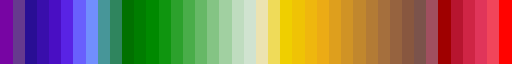

In [208]:

cmaps.precip2_17lev
cmaps.wh_bl_gr_ye_re
cmaps.WhiteBlueGreenYellowRed
cmaps.Carbone42



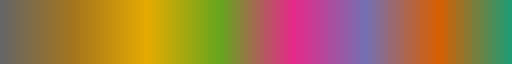

In [213]:

cmaps.MPL_Dark2_r



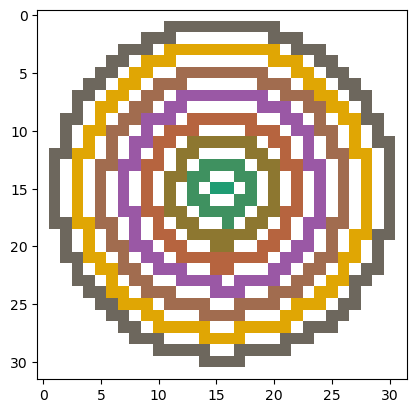

In [297]:


# plt.imshow(fall[48:80,215:247], origin='upper', vmin=0.00003, cmap='Carbone42', interpolation='none')
plt.imshow(fall[50:82,217:249], origin='upper', norm='log', vmin=0.005, cmap='MPL_Dark2_r', interpolation=None)



C:\Users\manuel\miniconda3\envs\py39\lib\site-packages\pyproj\crs\crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


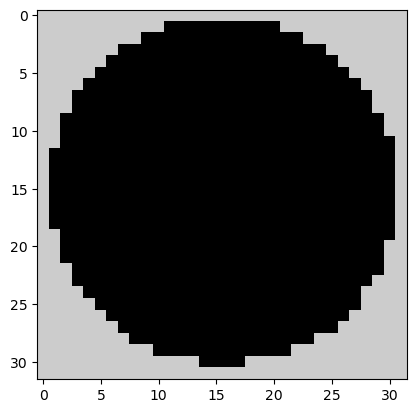

In [298]:



# burn the mask
# convert LINESTRING to POLYGON (in shapely). ".iloc[0]" for the largest/outter RADII
# https://stackoverflow.com/a/2975194/5885810
OUTER_RING = ( ALL_RINGS.geometry.iloc[0] ).convex_hull
# create a GEOPANDAS from a SHAPELY so you can JSON.it
# https://stackoverflow.com/a/51520122/5885810
tmp = gdal.Rasterize('',
    gpd.GeoSeries([ OUTER_RING ]).to_json(), xRes=X_RES, yRes=Y_RES, allTouched=True,
    burnValues=1, noData=0, outputType=gdal.GDT_Int16, targetAlignedPixels=True,
    outputBounds=[llim, blim, rlim, tlim], outputSRS=pp.CRS.from_wkt(WKT_OGC).to_proj4(), format='MEM')
    #, width=int(abs(rlim-llim)/X_RES), height=int(abs(tlim-blim)/X_RES) )
mask = tmp.ReadAsArray()
tmp = None

plt.imshow(mask[50:82,217:249], origin='upper', vmin=.0, cmap='nipy_spectral_r')#, interpolation='nearest')




THIS IS WHAT NEEDS TO BE INTERPOLATED!!


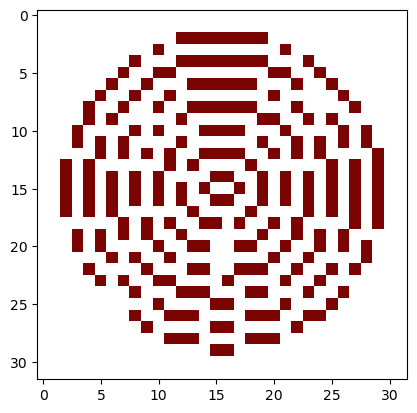

In [299]:


# re-touching the mask...to do a proper interpolation
mask[np.where(fall!=0)] = 0


plt.imshow(mask[50:82,217:249], origin='upper', norm='log', vmin=0.005, cmap='turbo', interpolation='none')



now we interpol

In [300]:

# note that this is done "in real time"
fill.fillnodata(np.ma.array(fall, mask=mask), mask=None, max_search_distance=4.0, smoothing_iterations=2)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [284]:

print( YS.shape )
print( XS.shape )


(470,)
(408,)


In [303]:



# ANOTHER VISUALISATION
# you have to run 'all_radii' [above in LOTR]


# first do 'fall' and/or 'mask' in RASTERIZE
da = xr.DataArray(data=fall, dims=['y','x'], coords={'x':XS, 'y':YS},)
pa = xr.DataArray(data=mask, dims=['y','x'], coords={'x':XS, 'y':YS},)




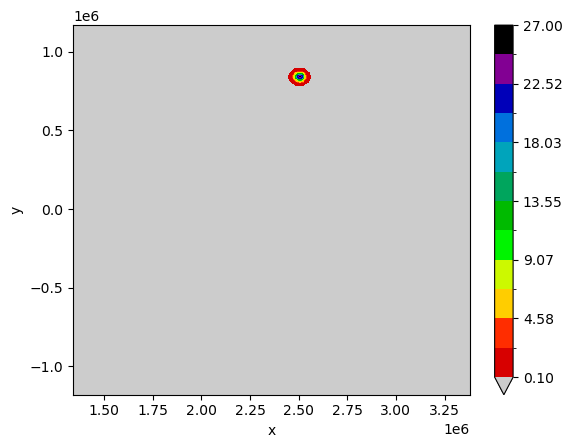

In [304]:

da.plot(cmap='nipy_spectral_r', levels=13, vmin=0.1,vmax=27)


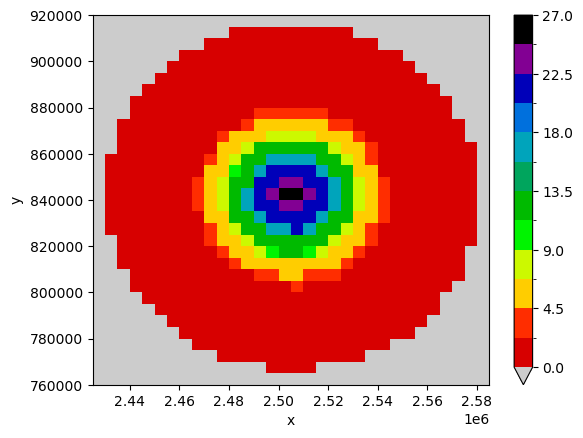

In [306]:
# FIND YOUR SLICES
da.isel( {'x':slice(217,249), 'y':slice(50,82),} ).plot(cmap='nipy_spectral_r', levels=13, vmin=0.005,vmax=27)


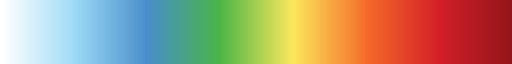

In [177]:
cmaps.precip2_17lev
cmaps.wh_bl_gr_ye_re
cmaps.WhiteBlueGreenYellowRed



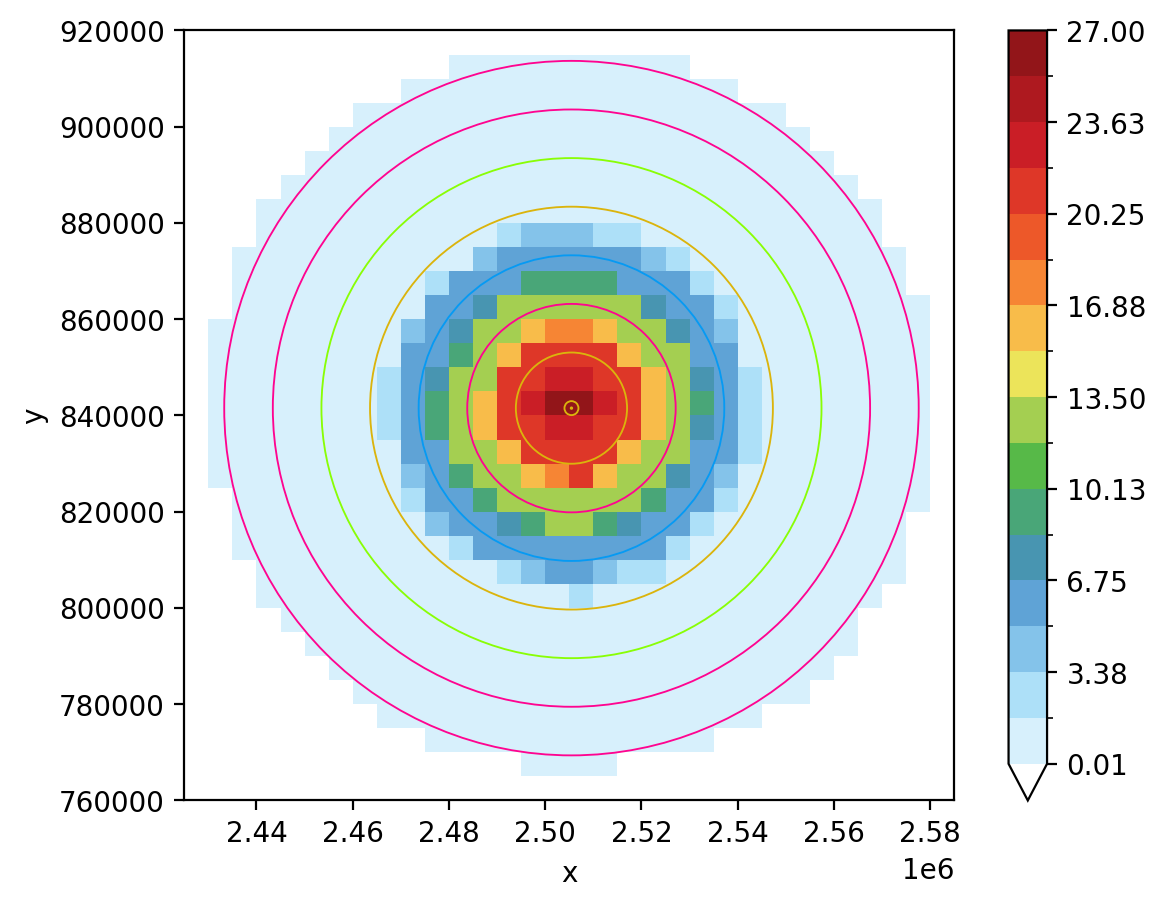

<Figure size 640x480 with 0 Axes>

In [307]:


# TO PLOT IT RIGHT ONE HAS TO USE XARRAY!
fig, ax = plt.subplots(figsize=(7,5), dpi=200)
ax.set_aspect('equal')
# da.isel( {'x':slice(115,130), 'y':slice(200,215)} ).plot(
da.isel( {'x':slice(217,249), 'y':slice(50,82),} ).plot( cmap='WhiteBlueGreenYellowRed', levels=17, vmin=0.005,vmax=27, ax=ax)
# RINGS[23].plot(color='xkcd:bright aqua', lw=.47, ax=ax)
for rr in all_radii[ posx ] *1e3:
    circ = Circle((CENTS[posx][0], CENTS[posx][1]), rr, alpha=1, facecolor='None', lw=0.67,
        edgecolor=npr.choice(['xkcd:lime green','xkcd:gold','xkcd:electric pink','xkcd:azure']))
    ax.add_patch(circ)
# # https://stackoverflow.com/a/64035939/5885810  (add vertical lines)
# plt.vlines(x=np.arange(1920000,1990000,5000), ymin=-180000, ymax=-100000, colors='xkcd:off white', ls='dotted', lw=0.09)
# plt.hlines(y=np.arange(-110000,-180000,-5000), xmin=1910000, xmax=1990000, colors='xkcd:off white', ls='dotted', lw=0.09)
plt.show()
# plt.savefig(f'tmp_raster_xarray_n{posx}_pol.pdf', bbox_inches='tight',pad_inches=0.02, facecolor=fig.get_facecolor())
plt.close()
plt.clf()



In [247]:
print(RINGS[0])

        rain                                           geometry
0   0.005983  LINESTRING (2577603.046 841520.419, 2577295.24...
0   0.053399  LINESTRING (2567503.046 841520.419, 2567163.10...
0   0.342809  LINESTRING (2557403.046 841520.419, 2557024.23...
0   1.583055  LINESTRING (2547303.046 841520.419, 2546877.02...
0   5.258540  LINESTRING (2537203.046 841520.419, 2536720.62...
0  12.564893  LINESTRING (2527103.046 841520.419, 2526560.12...
0  21.596182  LINESTRING (2517003.046 841520.419, 2516437.52...
0  26.700520  LINESTRING (2506903.046 841520.419, 2506708.17...
0  26.790922  LINESTRING (2505598.493 841520.419, 2505578.39...


In [ ]:
[array([72.15455275, 62.05455275, 51.95455275, 41.85455275, 31.75455275,
        21.65455275, 11.55455275,  1.45455275,  0.15      ]),

In [249]:
print( all_radii[0])

[72.15455275 62.05455275 51.95455275 41.85455275 31.75455275 21.65455275 11.55455275  1.45455275  0.15      ]


FOR LATER...

In [308]:
SHP_FILE = '../model_input/HAD_basin.shp'                # catchment shape-file in WGS84

wtrwgs = gpd.read_file( SHP_FILE )
# transform it into EPSG:42106 & make the buffer    # this code does NOT work!
# https://gis.stackexchange.com/a/328276/127894     (geo series into gpd)
wtrshd = wtrwgs.to_crs( crs = WKT_OGC )          # //epsg.io/42106.wkt

In [309]:


tmp = gdal.Rasterize('', wtrshd.to_json(), format='MEM', add=0
    , xRes=X_RES, yRes=Y_RES, noData=0, burnValues=1, allTouched=True
    , outputType=gdal.GDT_Int16, outputBounds=[llim, blim, rlim, tlim]
    , targetAlignedPixels=True
    # ,targetAlignedPixels=False # (check: https://gdal.org/programs/gdal_rasterize.html#cmdoption-gdal_rasterize-tap)
# UPDATE needed for outputSRS [in WKT instead of PROJ4]
    , outputSRS=pp.CRS.from_wkt(WKT_OGC).to_proj4()
    # # , width=(abs(rlim-llim)/X_RES).astype('u2'), height=(abs(tlim-blim)/X_RES).astype('u2')
    )
CATCHMENT_MASK = tmp.ReadAsArray().astype('u1')
tmp = None

C:\Users\manuel\AppData\Local\Temp\ipykernel_33800\1995956562.py:1: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  tmp = gdal.Rasterize('', wtrshd.to_json(), format='MEM', add=0
C:\Users\manuel\miniconda3\envs\py39\lib\site-packages\pyproj\crs\crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


XPORT CATCHMENT AS NUMPY

In [310]:
#~XPORT.IT.as.NUMPY~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.save('tre_catchment-mask', CATCHMENT_MASK.astype('u1'), allow_pickle=True, fix_imports=True)